## Calibration of model parameters (BLACK and SCHOLES, MERTON)
The **Implied Volatility** is that value $\\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
$$ BS(S, K, T, r, \sigma) = P  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.


In [1]:
from functions.MERTONpricer import Merton_pricer
from functions.BSpricer import BS_pricer
from functions.KOUpricer import Kou_pricer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
import scipy.stats as ss
import scipy.optimize as scpo


Let's retrieve the historic prices for european call and put options starting from 2016-01-20 and expiring 1 year later.

In [2]:
df_call = pd.read_csv('data/options_spx_call_2016.csv')
df_put = pd.read_csv('data/options_spx_put_2016.csv')

df_call['C_Midpoint'] = abs(df_call['C_BID'] + df_call['C_ASK']) / 2
df_put['P_Midpoint'] = abs(df_put['P_BID'] + df_put['P_ASK']) / 2
df_call['C_Spread'] = df_call['C_BID'] - df_call['C_ASK']
df_put['P_Spread'] = df_put['P_BID'] - df_put['P_ASK']

q = 0       # dividend yield
r = 0.1     # risk-free interest rate
sigma = 0.2 #volatility (variance of diffusion process)
S0 = df_call.iloc[0]['UNDERLYING_LAST']
T = 1
strikes = np.arange(50,151,5)
call_strikes = df_call['STRIKE']    # array of K
put_strikes = df_put['STRIKE']
exercise = 'european'

call_prices = df_call['C_Midpoint']
put_prices = df_put['P_Midpoint']

Let's initialize an object of class BS_pricer which is able to find the theoretical price of the options, given the parameters.

In [3]:
BS = BS_pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=0.1, q = q, sigma=0.12, lambd=0.5, meanJ=-0.1, stdJ=0.2, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.12, lambd=0.5, p=0.6, eta1=10, eta2=5, exercise=exercise)

call_th_prices = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou'])

for i, K in enumerate(call_strikes):
    bs = BS.closed_formula_call(K)
    mert = Merton.closed_formula_call(K)
    kou = Kou.closed_formula_call(K)
    call_th_prices.loc[i] = [bs, mert, kou]

print(f'Theoretical call options prices:')
print(call_th_prices)


Theoretical call options prices:
    BlackScholes      Merton         Kou
0     408.620604  414.279528  408.433657
1     389.398114  394.489038  387.890420
2     370.591178  374.959376  367.611205
3     352.224219  355.714767  347.635046
4     334.320137  336.782093  328.004305
5     316.900061  318.190800  308.764021
6     299.983133  299.972657  289.961063
7     283.586327  282.161361  271.643122
8     267.724300  264.791999  253.857593
9     252.409289  247.900367  236.650380
10    237.651041  231.522201  220.064704
11    223.456778  215.692316  204.139960
12    209.831207  200.443729  188.910680
13    196.776552  185.806783  174.405658
14    184.292620  171.808326  160.647263
15    172.376900  158.470986  147.650972
16    161.024675  145.812564  135.425133
17    150.229161  133.845579  123.970960
18    139.981660  122.576979  113.282735
19    130.271721  112.008029  103.348212


PUT PRICES:

In [4]:
put_th_prices = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou'])

for i, K in enumerate(put_strikes):
    bs = BS.closed_formula_put(K)
    mert = Merton.closed_formula_put(K)
    kou = Kou.closed_formula_put(K)
    put_th_prices.loc[i] = [bs, mert, kou]

print(f'Theoretical put options prices:')
print(put_th_prices)

Theoretical put options prices:
    BlackScholes      Merton         Kou
0      19.501408   25.160332   19.314461
1      22.899853   27.990778   21.392159
2      26.713854   31.082051   23.733880
3      30.967830   34.458378   26.378656
4      35.684683   38.146639   29.368851
5      40.885542   42.176282   32.749503
6      46.589550   46.579074   36.567480
7      52.813679   51.388714   40.870475
8      59.572588   56.640286   45.705881
9      66.878513   62.369591   51.119604
10     74.741200   68.612360   57.154863
11     83.167873   75.403410   63.851054
12     92.163237   82.775759   71.242710
13    101.729517   90.759748   79.358623
14    111.866520   99.382227   88.221164
15    122.571736  108.665822   97.845808
16    133.840446  118.628336  108.240905
17    145.665868  129.282286  119.407667
18    158.039302  140.634622  131.340377
19    170.950299  152.686607  144.026789


In [5]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method, disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method == 'brent':
        x, res = scpo.brentq(obj_fun, a=1e-15, b=500, full_output=True)
        if res.converged:
            return x

    if method =='fsolve':
        #X0 = [0.03, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 1, 2]   # set of
        X0 = [0.1, 0.5, 1, 3]
        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.5
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result


    if disp:
        return -1

Let's now compute the implied volatilities from the true market prices *call_prices*.

In [6]:
IV_BS = []; IV_M = []; IV_K = []

for i in range(len(call_prices)):
    IV_BS.append(implied_volatility(call_th_prices['BlackScholes'].values[i], S=S0, strike=call_strikes[i], t=T, rate=r,q=q, type_o='call', method='newton') )
    IV_M.append(implied_volatility(call_th_prices['Merton'].values[i], S=S0, strike = call_strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_K.append(implied_volatility(call_th_prices['Kou'].values[i], S=S0, strike = call_strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))

imp_vol_call = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou'])
imp_vol_call['BlackScholes'] = IV_BS
imp_vol_call['Merton'] = IV_M
imp_vol_call['Kou'] = IV_K

print(f'Implied volatilities found by each model for call options:\n{imp_vol_call}')

Implied volatilities found by each model for call options:
    BlackScholes    Merton       Kou
0            0.2  0.216304  0.199432
1            0.2  0.213534  0.195783
2            0.2  0.210766  0.192301
3            0.2  0.208013  0.189003
4            0.2  0.205288  0.185904
5            0.2  0.202606  0.183014
6            0.2  0.199980  0.180341
7            0.2  0.197424  0.177887
8            0.2  0.194950  0.175653
9            0.2  0.192570  0.173637
10           0.2  0.190295  0.171832
11           0.2  0.188131  0.170231
12           0.2  0.186088  0.168826
13           0.2  0.184169  0.167608
14           0.2  0.182377  0.166566
15           0.2  0.180716  0.165692
16           0.2  0.179186  0.164976
17           0.2  0.177787  0.164409
18           0.2  0.176516  0.163982
19           0.2  0.175374  0.163689


In [7]:
IV_BS = []; IV_M = []; IV_K = []

for i in range(len(put_prices)):
    IV_BS.append(implied_volatility(put_th_prices['BlackScholes'].values[i], S=S0, strike=put_strikes[i], t=T, rate=r, q=q, type_o='put', method='newton' ) )
    IV_M.append(implied_volatility(put_th_prices['Merton'].values[i], S=S0, strike = put_strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_K.append(implied_volatility(put_th_prices['Kou'].values[i], S=S0, strike = put_strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))

imp_vol_put = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou'])
imp_vol_put['BlackScholes'] = IV_BS
imp_vol_put['Merton'] = IV_M
imp_vol_put['Kou'] = IV_K

print(f'Implied volatilities found by each model for put options:\n {imp_vol_put}')

Implied volatilities found by each model for put options:
     BlackScholes    Merton       Kou
0            0.2  0.216304  0.199432
1            0.2  0.213534  0.195783
2            0.2  0.210766  0.192301
3            0.2  0.208013  0.189003
4            0.2  0.205288  0.185904
5            0.2  0.202606  0.183014
6            0.2  0.199980  0.180341
7            0.2  0.197424  0.177887
8            0.2  0.194950  0.175653
9            0.2  0.192570  0.173637
10           0.2  0.190295  0.171832
11           0.2  0.188131  0.170231
12           0.2  0.186088  0.168826
13           0.2  0.184169  0.167608
14           0.2  0.182377  0.166566
15           0.2  0.180716  0.165692
16           0.2  0.179186  0.164976
17           0.2  0.177787  0.164409
18           0.2  0.176516  0.163982
19           0.2  0.175374  0.163689


Plot of the implied volatilities with respect to the strike price.

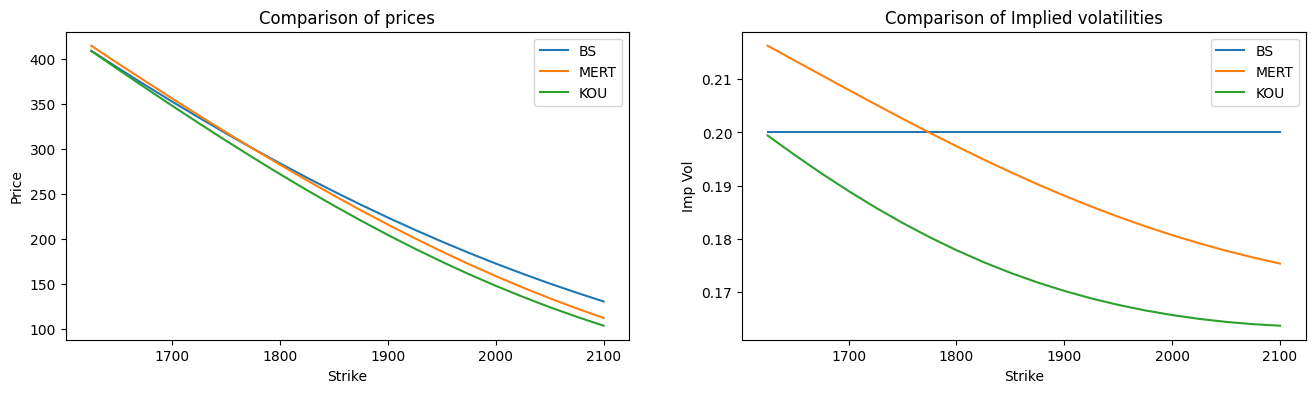

In [8]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(call_strikes, call_th_prices['BlackScholes'], label="BS"); ax1.plot(call_strikes, call_th_prices['Merton'], label="MERT")
ax1.plot(call_strikes, call_th_prices['Kou'], label="KOU")
ax1.set_title("Comparison of prices"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Price")

ax2.plot(call_strikes, imp_vol_call['BlackScholes'], label="BS"); ax2.plot(call_strikes, imp_vol_call['Merton'], label="MERT")
ax2.plot(call_strikes, imp_vol_call['Kou'], label="KOU")
ax2.set_title("Comparison of Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")

ax1.legend(); ax2.legend(); plt.show()

## Calibration of Merton Jump Diffusion parameters
First we'll initialize a starting point in the array $x_0 = [σ, λ, m, v]$
and we set bounds for the 4 parameters. Then we use the method
1. **curve_fit** of scipy.optimize. It uses the trf method when the parameters are bounded and the Levemberg-Marquadt method for unbounded parameters.

In [9]:
x0 = [0.15, 1, 0.1, 1] # initial guess: [σ, λ, m, v]
bounds = ( [0, 0, -10, 0.1], [np.inf, np.inf, 10, 5] )

def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)
#

- Method 1. curve_fit of scipy.optimize. It uses the trf method when the parameters are bounded and the Levemberg-Marquadt method for unbounded parameters.

In [10]:
res1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
lambdt = round(res1[0][1],2)
mt = round(res1[0][2],2)
vt = round(res1[0][3],5)

print('METHOD 1: CURVE_FIT (trf)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Jump Mean = ', mt)
print('> Calibrated Jump St. dev.  = ', vt)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] =  0.02322
> Calibrated Jump intensity [λ] =  0.12
> Calibrated Jump Mean =  0.21
> Calibrated Jump St. dev.  =  0.1


In [11]:
res1_2 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0)

sigt2 = round(res1_2[0][0],5)
lambdt2 = round(res1_2[0][1],2)
mt2 = round(res1_2[0][2],2)
vt2 = round(res1_2[0][3],5)

print('METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)')
print('> Calibrated Volatlity [σ] = ', sigt2)
print('> Calibrated Jump intensity [λ] = ', lambdt2)
print('> Calibrated Jump Mean = ', mt2)
print('> Calibrated Jump St. dev.  = ', vt2)

C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\BSpricer.py:71: RuntimeWarning: overflow encountered in exp
  return S0 * np.exp(-q*ttm) * ss.norm.cdf(d1) - K * np.exp(-r * ttm) * ss.norm.cdf(d2)
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:54: RuntimeWarning: overflow encountered in scalar power
  V += (np.exp(-mean * self.lambd * self.ttm) * (mean * self.lambd * self.ttm) ** k) / k_fact * \
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:54: RuntimeWarning: invalid value encountered in scalar multiply
  V += (np.exp(-mean * self.lambd * self.ttm) * (mean * self.lambd * self.ttm) ** k) / k_fact * \
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:54: RuntimeWarning: overflow encountered in exp
  V += (np.exp(-mean * self.lambd * self.ttm) 

METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)
> Calibrated Volatlity [σ] =  9e-05
> Calibrated Jump intensity [λ] =  0.57
> Calibrated Jump Mean =  0.08
> Calibrated Jump St. dev.  =  0.03183


- Method 2. minimize(method=’SLSQP’)

In [12]:
x0 = [0.2, 0.5, -0.1, 1] # initial guess: [σ, λ, m, v]
bounds = [(0.01, 3), (0, np.inf), (-5, 5),  (0, 5)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, mean, std = x
    Mert = Merton_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, lambd=lamb, meanJ=mean, stdJ=std, exercise=exercise)
    return np.sum((Mert.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)

print(res2)
sigt, lambdt, mt, vt = res2.x

# Print the results
print('> METHOD 2: MINIMIZE (SLSQP)')
print('Calibrated Volatility [σ] =', round(sigt, 5))
print('Calibrated Jump Intensity [λ] =', round(lambdt, 2))
print('Calibrated Jump Mean [m] =', round(mt, 2))
print('Calibrated Jump St. dev. [v] =', round(vt, 2))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 721572.5229159031
       x: [ 1.427e-01  3.492e-01 -1.299e+00  8.381e-01]
     nit: 7
     jac: [ 1.735e+06  5.013e+06 -9.380e+05 -2.063e+05]
    nfev: 20
    njev: 3
> METHOD 2: MINIMIZE (SLSQP)
Calibrated Volatility [σ] = 0.14268
Calibrated Jump Intensity [λ] = 0.35
Calibrated Jump Mean [m] = -1.3
Calibrated Jump St. dev. [v] = 0.84


## Calibration of Kou Jump Diffusion parameters

In [17]:
x0 = [0.1, 0.5, 0.4, 5, 5] # initial guess: [σ, λ, p, η_1, η_1]
bounds = ( [0, 0, 0, 0, 0], [4, 10, 0.9,  10, 10] )

def f_Kou(x, sigma, lambd, p, eta1, eta2):
    KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return KouJD.closed_formula_call(x)

Method scipy.optimize: curve_fit

In [18]:
res1 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
lambdt = round(res1[0][1],2)
pt = round(res1[0][2],2)
eta1_t = round(res1[0][3],1)
eta2_t = round(res1[0][4],1)

print('METHOD 1: CURVE_FIT (trf)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Upward Jump probability = ', pt)
print('> Calibrated Rate of Exp. 1  = ', eta1_t)
print('> Calibrated Rate of Exp. 2  = ', eta2_t)


METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] =  0.02729
> Calibrated Jump intensity [λ] =  0.0
> Calibrated Upward Jump probability =  0.9
> Calibrated Rate of Exp. 1  =  1.0
> Calibrated Rate of Exp. 2  =  10.0


#### Method 2: minimize function

In [22]:
x0 = [0.1, 0.5, 0.5, 8, 4] # initial guess: [σ, λ, p, η_1, η_1]
bounds = [(0, 4), (0, 10), (0, 1),  (0, 10), (0,10)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, p, eta1, eta2 = x
    KouJD = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return np.sum((KouJD.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)
print(res2)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 159610.53038636016
       x: [ 1.000e-01  5.000e-01  5.000e-01  8.000e+00  4.000e+00]
     nit: 5
     jac: [-9.946e+05 -1.566e+05  3.896e+04  6.189e+03  1.362e+04]
    nfev: 6
    njev: 1


Let's select a sample of the original dataframe in order to speed up the computation.

In [25]:
# Sample of rows of the call dataframe
call_resized = df_call.sample(n=5)
c_strikes_resized = call_resized['STRIKE']
c_prices_resized = call_resized['C_Midpoint']
# print(call_resized, c_strikes_resized, c_prices_resized)

x0 = [0.1, 0.5, 0.5, 8, 4] # initial guess: [σ, λ, p, η_1, η_1]

bounds1 = ( [0, 0, 0, 0, 0], [4, 10, 1,  10, 10] )
res1 = scpo.curve_fit(f_Kou, c_strikes_resized, c_prices_resized, p0=x0, bounds=bounds1)
print(res1[0])

bounds2 = [(0, 4), (0, 10), (0, 1),  (0, 10), (0,10)]
additional_args = (c_strikes_resized, c_prices_resized)
res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds2, tol=1e-20)
print(res2)

    QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE   C_BID   C_ASK  STRIKE   
12  2016-01-20          1859.48  2017-01-20  103.00  106.10  1925.0  \
16  2016-01-20          1859.48  2017-01-20   60.40   63.20  2025.0   
13  2016-01-20          1859.48  2017-01-20   91.20   94.29  1950.0   
10  2016-01-20          1859.48  2017-01-20  128.49  131.80  1875.0   
15  2016-01-20          1859.48  2017-01-20   70.00   72.91  2000.0   

    C_Midpoint  C_Spread  
12     104.550     -3.10  
16      61.800     -2.80  
13      92.745     -3.09  
10     130.145     -3.31  
15      71.455     -2.91   12    1925.0
16    2025.0
13    1950.0
10    1875.0
15    2000.0
Name: STRIKE, dtype: float64 12    104.550
16     61.800
13     92.745
10    130.145
15     71.455
Name: C_Midpoint, dtype: float64


c:\users\ornel\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[2.39026251e-03 3.86810760e-01 1.00000000e+00 9.99553563e+00
 9.99976995e+00]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2947.138970000306
       x: [ 9.960e-02  4.750e-01  6.740e-01  8.555e+00  5.432e+00]
     nit: 40
     jac: [-2.023e-02 -5.157e-03  6.104e-05  3.967e-04  2.136e-04]
    nfev: 544
    njev: 40


In [27]:
sigt, lambdt, pt, eta1_t, eta2_t = res2.x

print('METHOD 2: MINIMIZE (SQLSP)')
print('> Calibrated Volatlity [σ] = ', round(sigt, 2))
print('> Calibrated Jump intensity [λ] = ', round(lambdt,2))
print('> Calibrated Upward Jump probability = ', round(pt,2))
print('> Calibrated Rate of Exp. 1  = ', round(eta1_t,2))
print('> Calibrated Rate of Exp. 2  = ', round(eta2_t,2))

METHOD 2: MINIMIZE (SQLSP)
> Calibrated Volatlity [σ] =  0.1
> Calibrated Jump intensity [λ] =  0.48
> Calibrated Upward Jump probability =  0.67
> Calibrated Rate of Exp. 1  =  8.55
> Calibrated Rate of Exp. 2  =  5.43
